In [226]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, Dropout, Conv2D, Conv2DTranspose, TimeDistributed, Bidirectional, ConvLSTM2D
from keras import backend as K
import tensorflow as tf
from keras.optimizers import RMSprop, Adam, SGD
from keras.losses import binary_crossentropy
from losses import *
import math

from datahandler import DataHandler
from models.unet_se import *
from models.unet import *
from models.resnet_fcn import *
from models.resnet_se_fcn import *
from models.resnet_fcn import *
from models.vgg19_fcn import *
from models.vgg19_se_fcn import *
from models.unet_resnet import *

from generator import *
from params import *
from callbacks import getCallbacks
from data_loader import *

from tqdm import tqdm
import os
import skimage.io as io

from keras.models import *
from keras import backend as K

import random

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score


In [227]:
def getModel(name):
    if name == 'unet':
        print('using unet as first model')
        model = getUnet()
    elif name == 'resnetFCN':
        print('using resnetFCN as first model')
        model = getResnet50FCN()
    elif model_type == 'resnetSEFCN':
        print('using resnetSEFCN as first model')
        model = getResnetSE50FCN()
    elif name == 'vgg19FCN':
        print('using vgg19FCN as first model')
        model = getVGG19FCN()
    elif name == 'vgg19SEFCN':
        print('using vgg19SEFCN as first model')
        model = getVGG19SEFCN()
    elif name == 'UnetResNet18':
        print('using UnetResNet18 as first model')
        model = getUnetResnet18()
    elif name == 'UnetResNet18SE':
        print('using UnetResNet18SE as first model')
        model = getUnetResnet18(se_version = True)
    else:
        print('using UnetResNet18SE as first model')
        model = getSEUnet()

    return model

def lstmGenerator(images, batch_size, pre_model, pre_graph):
    i=0
    reset = False

    while True:
        with pre_graph.as_default():
            batch_features = []
            c = batch_size * i

            if reset:
                i = 0
                c = 0
                reset = False

            for j in range(c, c + batch_size):

                if j >= len(images):
                    reset = True
                    continue

                if j == 0:
                    res1 =  np.expand_dims(np.zeros(images[j].shape), axis=0)
                else:
                    img1 = np.expand_dims(images[j-1], axis=0)
                    res1 = pre_model.predict(img1)

                img2 = np.expand_dims(images[j], axis=0)
                res2 = pre_model.predict(img2)

                if j == images.shape[0]-1:
                    res3 = np.expand_dims(np.zeros(images[j].shape), axis=0)
                else:
                    img3 = np.expand_dims(images[j+1], axis=0)
                    res3 = pre_model.predict(img3)

                res = np.concatenate((res1,res2,res3), axis=0)
                res[res>=0.5] = 1
                res[res<0.5] = 0

                batch_features.append(res)

            i += 1

            if len(batch_features) == 0:
                res1 = np.expand_dims(np.zeros(images[0].shape), axis=0)
                res2 = np.expand_dims(np.zeros(images[0].shape), axis=0)
                res3 = np.expand_dims(np.zeros(images[0].shape), axis=0)
                res = np.concatenate((res1,res2,res3), axis=0)


                batch_features.append(res)

            yield np.array(batch_features)

def lstmModel():

    with lstm_graph.as_default():

        inputs = Input((3, 256, 256, 1))

        bclstm = Bidirectional(ConvLSTM2D(32, 3, return_sequences = True, padding='same', activation = 'relu'))(inputs)
        bclstm = Bidirectional(ConvLSTM2D(32, 3, return_sequences = True, padding='same', activation = 'relu'))(bclstm)

        pool = TimeDistributed(MaxPooling2D(pool_size=2))(bclstm)

        bclstm = Bidirectional(ConvLSTM2D(64, 3, return_sequences = True, padding='same', activation = 'relu'))(pool)
        bclstm = Bidirectional(ConvLSTM2D(64, 3, return_sequences = True, padding='same', activation = 'relu'))(bclstm)
        bclstm = Bidirectional(ConvLSTM2D(64, 3, padding='same', activation = 'relu'))(bclstm)

        up = Conv2DTranspose(64,3, strides=2, padding='same', activation = 'relu')(bclstm)
        conv = Conv2D(64, 3, activation = 'relu', padding='same')(up)

        outputs = Conv2D(1, (1,1), activation = 'sigmoid')(conv)

        model = Model(input = inputs, output = outputs)

        model.compile(optimizer = Adam(lr = 1e-4),
                loss = binary_crossentropy, metrics = [dice_coef])

        return model

In [311]:
model_type = 'unet'

i = 4

K.clear_session()

image_files, mask_files = load_data_files('data/kfold_data/')

skf = getKFolds(image_files, mask_files, n=10)

kfold_indices = []
for train_index, val_index in skf.split(image_files, mask_files):
    kfold_indices.append({'train': train_index, 'val': val_index})


#Get data and generators
dh = DataHandler()

pre_graph = tf.get_default_graph()

with pre_graph.as_default():
        pre_model = getModel(model_type)
        pre_model.load_weights('logs/%s/kfold_%s/kfold_%s_dice_DA_K%d/kfold_%s_dice_DA_K%d_weights.h5'%(
            model_type,model_type,model_type,i,model_type,i))


te_images, te_masks = dh.getKFoldData(image_files,
            mask_files, kfold_indices[i], eval=True)

using unet as first model


/home/alejandrovaldes/projects/fetal-brain-segmentation/models/unet.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)
Data aquisition: 100%|████████████████████████| 262/262 [04:36<00:00,  1.03it/s]


In [314]:
exp_name = 'kfold_%s_dice_LSTM_K%d'%('vgg19FCN', i)
#get parameters
params = getParams(exp_name, 'vgg19FCN', is_lstm=True)
lstm_graph = tf.get_default_graph()
with lstm_graph.as_default():
        model = lstmModel()
        print('loading weights from %s'%params['checkpoint']['name'])
        model.load_weights(params['checkpoint']['name'])


/home/alejandrovaldes/.virtualenvs/fetal-brain-segmentation-9O2pP5m0/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


loading weights from ./logs/vgg19FCN_LSTM/kfold_vgg19FCN_LSTM/kfold_vgg19FCN_dice_LSTM_K4/kfold_vgg19FCN_dice_LSTM_K4_weights.h5


In [315]:
print(len(te_images))

10563


470


<Figure size 432x288 with 0 Axes>

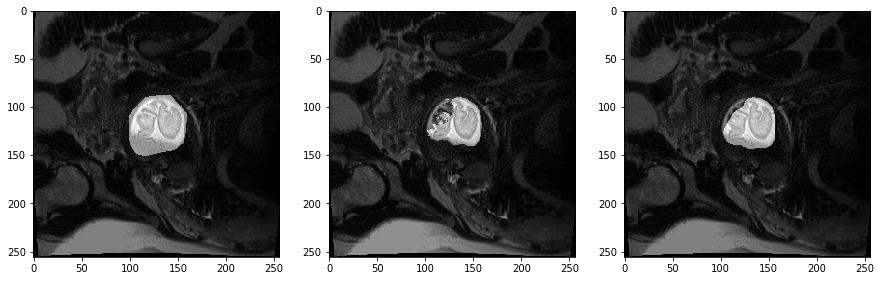

In [477]:
j = random.randint(0, len(te_images))
plt.gray()
#j = 470
#j = 1744
mask = te_masks[j]
mask[mask==255] = 1

print(j)
with pre_graph.as_default():
        pre_r = pre_model.predict(np.expand_dims(te_images[j],0))
        pre_r[pre_r<0.5] = 0
        pre_r[pre_r>0.5] = 1

with pre_graph.as_default():
        pre_r1 = pre_model.predict(np.expand_dims(te_images[j-1],0))
        pre_r2 = pre_model.predict(np.expand_dims(te_images[j],0))
        pre_r3 = pre_model.predict(np.expand_dims(te_images[j+1],0))
        pre = np.array([np.concatenate((pre_r1, pre_r2, pre_r3), axis=0)])
        pre[pre >= 0.5] = 1
        pre[pre < 0.5] = 0
        
with lstm_graph.as_default():
    r = model.predict(pre)
    r[r<0.5] = 0
    r[r>0.5] = 1

f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(te_images[j] + te_masks[j] * 255))
axarr[1].imshow(np.squeeze(te_images[j] + pre_r * 200))
axarr[2].imshow(np.squeeze(te_images[j] + r * 255))



In [464]:
print(f1_score(pre_r.flatten(), mask.flatten()))
print(recall_score(pre_r.flatten(), mask.flatten()))
print(precision_score(pre_r.flatten(), mask.flatten()))
print()
print(f1_score(r.flatten(), mask.flatten()))
print(recall_score(r.flatten(), mask.flatten()))
print(precision_score(r.flatten(), mask.flatten()))

0.913991280221958
0.9742289818335446
0.8607689436356849

0.9397211859414883
0.9913007456503728
0.89324374766704
